In [1]:
import numpy as np
#from numpy.random import choice
import matplotlib.pyplot as plt
from stl import mesh
from mpl_toolkits import mplot3d

### Getting basic Cherenkov light source for chroma
Based off of Soud's code at https://github.com/soudk/phys512/blob/master/project_cherenkov/NumbaCherenkov.ipynb

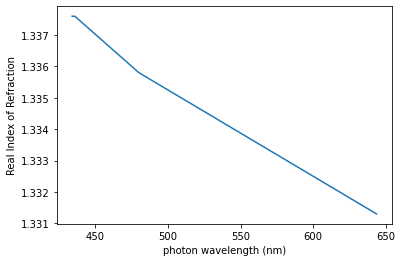

In [2]:
#In eV
energies = np.array([0.602, 0.689, 1.03,  1.926, 2.583, 2.845, 2.857, 3.124,3.457, 3.643, 3.812, 4.086, 4.511, 4.953, 5.474, 6.262, 7.000, 8.300, 10.00, 12.60])
#Refractive index of water from Segelstein, David J. The complex refractive index of water. Diss. University of Missouri--Kansas City, 1981.
n = np.array([1.303, 1.3120,   1.3239,   1.3313, 1.3358, 1.3376, 1.3376, 1.3392, 1.3423, 1.3442, 1.3460, 1.3486, 1.3540, 1.3619, 1.3723, 1.3960, 1.3960, 1.3960,1.3960, 1.3960])

#plt.plot(energies, n)

wavelengths = 1239.8/energies

freq = 3e17/wavelengths

#Only take the ~near visible range (where photomultiplier tubes are sensitive). 
#This is the tail of the Cherenkov emission spectrum.
cut = [3,7]
freq = freq[cut[0]:cut[1]]
wavelengths=wavelengths[cut[0]:cut[1]]
energies=energies[cut[0]:cut[1]]
n=n[cut[0]:cut[1]]

#radians, approx Cherenkov angle in optical (~0.5 degree precision)
thetaRel = 0.733 

plt.plot(wavelengths, n)
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Real Index of Refraction')
plt.show()

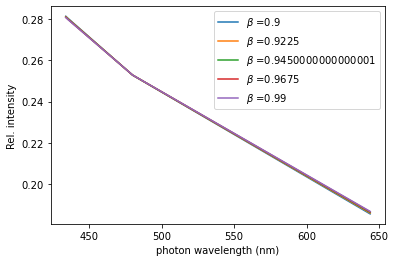

11253259774454.646
[1.12532598e+13 0.00000000e+00 0.00000000e+00 0.00000000e+00]
26578280701584.086
[1.12532598e+13 2.65782807e+13 0.00000000e+00 0.00000000e+00]
43559699091583.07
[1.12532598e+13 2.65782807e+13 4.35596991e+13 0.00000000e+00]
60612743850889.61
[1.12532598e+13 2.65782807e+13 4.35596991e+13 6.06127439e+13]
12498050844295.432
[1.24980508e+13 0.00000000e+00 0.00000000e+00 0.00000000e+00]
29481259027834.785
[1.24980508e+13 2.94812590e+13 0.00000000e+00 0.00000000e+00]
48284146466068.41
[1.24980508e+13 2.94812590e+13 4.82841465e+13 0.00000000e+00]
67166343095605.65
[1.24980508e+13 2.94812590e+13 4.82841465e+13 6.71663431e+13]
13654991118047.97
[1.36549911e+13 0.00000000e+00 0.00000000e+00 0.00000000e+00]
32179360436852.555
[1.36549911e+13 3.21793604e+13 0.00000000e+00 0.00000000e+00]
52675167233485.72
[1.36549911e+13 3.21793604e+13 5.26751672e+13 0.00000000e+00]
73257423830315.58
[1.36549911e+13 3.21793604e+13 5.26751672e+13 7.32574238e+13]
14732156964875.822
[1.4732157e+13 0

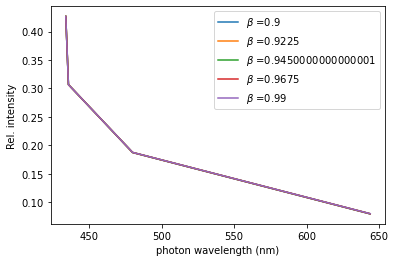

In [3]:
#I think mu(w) is constant in this range... So we can ignore the normalization then normalize later
b = np.linspace(0.9, 0.99, 5)

for beta in b:
    E_loss = 1.0/(4*np.pi) * freq*(1.0 - 1.0/(beta**2.0 * n**2.0))
    plt.plot(wavelengths,E_loss/np.abs(E_loss.sum()), '-',label=r'$\beta$ ='+str(beta) )
    
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Rel. intensity')
plt.legend()
plt.show()


for beta in b:
    E = 0
    E_loss = np.zeros(len(freq))
    for i, f in enumerate(freq):
        E += 1.0/(4*np.pi) * f*(1.0 - 1.0/(beta**2.0 * n[i]**2.0))
        print(E)
        E_loss[i] = E
    
        print(E_loss)
    plt.plot(wavelengths,E_loss/np.abs(E_loss.sum()), '-',label=r'$\beta$ ='+str(beta) )
    
plt.xlabel('photon wavelength (nm)')
plt.ylabel('Rel. intensity')
plt.legend()

In [4]:
def GetBeta(energy):
    gamma = energy/0.10566 #where does this come from? is it mc^2 in GeV ? Yup it's the muon mass
    return np.sqrt(1.0 - 1.0/(gamma**2.0))

print(GetBeta(1)) #1GeV to beta

0.9944023151622284


In [5]:
#Define custom data type here for particles
ptcl = np.dtype({'names':['x', 'y', 'z', 'px', 'py', 'pz', 'tracklength'], 
                 'formats':[np.double, np.double, np.double, np.double, np.double, np.double, np.double]})

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2' """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def perpendicular_vector(x):
    """Returns an arbitrary vector perpendicular to `x`."""
    a = np.zeros(3)
    a[np.argmin(abs(x))] = 1
    return np.cross(a,x)

In [6]:
'''
Give position, direction and length?
then can pick n number of photons along that path like here

- also momentum i guess - really I think I just want normalized momentum which is just direction???
but maybe I do need the full value for energy/wavelength?
'''


def propagateChere_init(parentPtcl):
    
    parentMomentum = np.array([parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']])
    trackLength = parentPtcl['tracklength'] 
    parentMomentumUnit = parentMomentum/np.linalg.norm(parentMomentum) 
    #so we assume the distance is set by the trackLength, and should use parentMomentumUnit
    # to calculate any distances traveled
    
    parentEntryPosition =  np.array([parentPtcl['x'], parentPtcl['y'], parentPtcl['z']])
    
    parentEndPosition = trackLength*parentMomentumUnit + parentEntryPosition
        
    dx, dy, dz = parentEndPosition - parentEntryPosition
    
    #print(parentEntryPosition)
    #print(parentEndPosition)
    
    photonsPerCm= 10 #100 /cm --> 10 /mm #this is set by the physics in the Frank-Tamm formula
    '''
    you may want this number to fluctuate around ~100 and not be exactly 100 per cm, which would make 
    it more realistic. However, for long track lengths, I'm not sure if it makes too much of a difference
    '''
    
    numPhotons = int(trackLength*photonsPerCm)
    
    photons = np.zeros(numPhotons, dtype=ptcl)
    #photons=np.zeros(numPhotons)

    #Soud used prange: 'Numba implements the ability to run loops in parallel'
    for i in range(numPhotons):
        
        numStepsAway = np.random.rand()*trackLength #pick a random point on the track
        
        #photon position
        photons[i]['x'] = parentEntryPosition[0]+numStepsAway*parentMomentumUnit[0]
        photons[i]['y'] = parentEntryPosition[1]+numStepsAway*parentMomentumUnit[1]
        photons[i]['z'] = parentEntryPosition[2]+numStepsAway*parentMomentumUnit[2]

        momentum=np.array([parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']])
#         parentMomentum = np.array([parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']])

        #First, rotate relative to z axis by Cherenkov angle
    # don't I want to rotate relative to the muon vector???
        c, s = np.cos(thetaRel), np.sin(thetaRel) #cos and sine
        
        #this finds a vector perpendicular to the parentMomentum one (unless parentMomentum==[0.,0.,1.0])
#         ux, uy, uz = np.cross(parentMomentum, [0.,0.,1.0]) #Need to rotate around axis out of page/into page
        ux, uy, uz = perpendicular_vector(parentMomentumUnit)
    
        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), \
                uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix

        momentum = R.dot(momentum)
#         print(momentum)
        
        #print( np.degrees(angle_between(parentMomentumUnit, momentum) ))

        #Now rotate random amount of phi about axis of parent trajectory
        phi=np.random.sample()*np.pi*2.0
#         print(phi)
        c, s = np.cos(phi), np.sin(phi) #cos and sine
#         ux, uy, uz = parentPtcl['px'], parentPtcl['py'], parentPtcl['pz']
        ux, uy, uz = parentMomentumUnit

        R = np.array([[c+ux*ux*(1.0-c), ux*uy*(1-c) - uz*s, ux*uz*(1-c) + uy*s], [uy*ux*(1-c)+uz*s, c+uy*uy *(1-c), \
                uy*uz*(1-c)-ux*s], [uz*ux*(1-c) - uy*s, uz*uy*(1-c)+ux*s, c+uz*uz * (1-c) ]])#rotation matrix
        momentum = R.dot(momentum)
        
#         print( np.degrees(angle_between(parentMomentum, momentum) ))
        
        #Photon momentum set so now leave track in a cherenkov cone 
        photons[i]['px'], photons[i]['py'], photons[i]['pz'] = momentum[0], momentum[1], momentum[2]
        
        #can get energy and therefore wavelength from momentum now here???
        
    #Return the photon hit positions - I want just their initial positions
    return photons

In [7]:
numMuons = 1
muon = np.zeros(numMuons, dtype=ptcl)

muon['x'] = 1.0 

# muon['px'] = 1.0
muon['pz'] = -2.0

muon['tracklength'] = 2.0

print(muon)

[(1., 0., 0., 0., 0., -2., 2.)]


In [8]:
photons = propagateChere_init(muon[0])

photonMomentum = np.array([photons['px'], photons['py'], photons['pz']])
# print(photonMomentum[:,0])

In [9]:
# print(len(photons))
# photons['x']

parentMomentum = np.array([muon[0]['px'], muon[0]['py'], muon[0]['pz']])
# print(parentMomentum)
parentMomentumUnit = parentMomentum/np.linalg.norm(parentMomentum)

trackLength = muon[0]['tracklength'] 

parentEntryPosition =  np.array([muon[0]['x'], muon[0]['y'], muon[0]['z']])
parentEndPosition = trackLength*parentMomentum/np.linalg.norm(parentMomentum) + parentEntryPosition
muonPath = np.array([parentEntryPosition, parentEndPosition]).T

# print(muonPath)

In [10]:
i = 0
photonMomentumOne = np.array([photons['px'][i], photons['py'][i], photons['pz'][i]])
# print(photonMomentum[:, :4])
photonMomentumUnitOne = photonMomentumOne/np.linalg.norm(photonMomentumOne)

angleOne = np.degrees(angle_between(parentMomentumUnit, photonMomentumUnitOne) )
print(angleOne)

photonMomentum = np.array([photons['px'], photons['py'], photons['pz']])
# print(photonMomentum[:, :4])
photonMomentumUnit = photonMomentum/np.linalg.norm(photonMomentum)

41.99780638308933


TypeError: object of type 'numpy.float64' has no len()

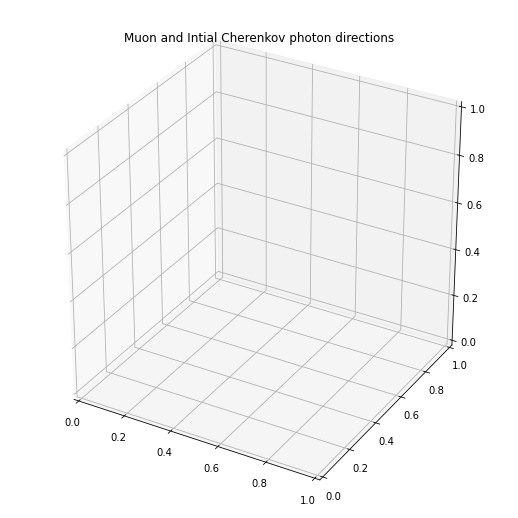

In [11]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

plt.title("Muon and Intial Cherenkov photon directions")#, pad=-1)

axes.plot3D(muonPath[0][0], muonPath[1][0], muonPath[2][0], 'red', marker='o')

axes.plot3D(muonPath[0], muonPath[1], muonPath[2], 'red')#, alpha=0.4)

p = axes.scatter3D(photons['x'], photons['y'], photons['z'], s=5)# , c=angle, cmap='viridis') #, vmin=0, vmax=ELs_max)
# Q = axes.quiver(photons['x'], photons['y'], photons['z'],photons['px'], photons['py'], photons['pz'], \
#                 length=0.0005, alpha=0.5, arrow_length_ratio=0)#, normalize=True, alpha=0.5)

Q = axes.quiver(photons['x'], photons['y'], photons['z'],photonMomentumUnit[0], photonMomentumUnit[1], photonMomentumUnit[2], \
                length=1, alpha=0.5, arrow_length_ratio=0.0)#, normalize=True, alpha=0.5)
    
# addGeometry(axes, parts=['PMTconnect','PMTGlass', 'OC'])  #'WT' ,

# axes.set_xlim3d(-300, 300)
# axes.set_ylim3d(-300, 300)
# axes.set_zlim3d(-7400, -6930)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

# axes.legend()

#change angle of view - (elev2ation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 90)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()